## Tutorial para usar SAMLoRA (modelo do SAM com LoRA)
- No Minerva-Dev, mude para a branch "141-feature-request-add-sam-segment-anything-model-to-minerva"
- Execute o código abaixo que é pra funcionar :v

### Modificações nesse notebook
- Os caminhos (dataset e weights) tirei o Path, pois uso a pathlib direto nas classes onde precisa
- Não uso transforms, então comentei
- Não uso ParihakaModule, então comentei
- Adicionei meu próprio Dataset e Module
- No evaluate model, mudei para pegar corretamente o retorno das masks que o SAM retorna e apliquei o softmax (como sempre fiz)
    - OBS: nessa célula comentei a parte que gera prints e plots por 2 motivos: primeiro que eu faço patches, então todas as imagens que aparecem plotadas são de patches e não de seções do volume. Segundo, como os patches são 255x255, há muitas amostras e o processo é demorado, e se eu botar pra plotar tudo trava o vscode.

- OBS: esse código executa o janelamento deslizante, e para isso, não implementei o Dataset e Dataloader que fiz, e sim o padrão do Minerva-Dev, para falicitar. Para executar, basta rodar o notebook inteiro, e ele vai gerar um arquivo .npy com todas as predições de todas as amostras de teste do parihaka.

In [1]:
import os
from pathlib import Path
from typing import Optional
import numpy as np
import lightning as L
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from minerva.models.nets.image.segment_anything.sam_lora import SAMLoRA
from minerva.data.datasets.supervised_dataset import SimpleDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.transforms.transform import _Transform, TransformPipeline
from minerva.data.readers.reader import _Reader

from torchmetrics import JaccardIndex

import tqdm

from typing import List, Optional, Tuple

import gc

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


## Variables

In [2]:
model_name = "SAM-ViT_B"
dataset_name = "seam_ai"
image_dir = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images"
annotations_dir = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"
image_height = 255
image_width = 255
image_channels = 1
batch_size = 1      # Plase set this to 1
num_classes = 6
predict_on_partition = "test"
ckpt_path = "/workspaces/Minerva-Discovery/my_experiments/sam_v1/checkpoints/final_train-raio-1.0-2024-11-27-epoch=11-val_loss=0.41.ckpt"
device = "cuda" if torch.cuda.is_available() else "cpu"
print_crosslines_every = 50
output_dir = Path(f"./logs/{dataset_name}/{model_name}/")
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {output_dir}")

Output directory: logs/seam_ai/SAM-ViT_B


## Helper functions

In [3]:
def plot_images(
    images,
    plot_title=None,
    subplot_titles=None,
    cmaps=None,
    filename=None,
    x_label=None,
    y_label=None,
    height=5,
    width=5,
    show=False
):
    num_images = len(images)

    # Create a figure with subplots (1 row, num_images columns), adjusting size based on height and width parameters
    fig, axs = plt.subplots(1, num_images, figsize=(width * num_images, height))

    # Set overall plot title if provided
    if plot_title is not None:
        fig.suptitle(plot_title, fontsize=16)

    # Ensure subplot_titles and cmaps are lists with correct lengths
    if subplot_titles is None:
        subplot_titles = [None] * num_images
    if cmaps is None:
        cmaps = ["gray"] * num_images

    # Plot each image in its respective subplot
    for i, (img, ax, title, cmap) in enumerate(
        zip(images, axs, subplot_titles, cmaps)
    ):
        im = ax.imshow(img, cmap=cmap)

        # Set title for each subplot if provided
        if title is not None:
            ax.set_title(title)

        # Add a colorbar for each subplot
        fig.colorbar(im, ax=ax)

        # Set x and y labels if provided
        if x_label:
            ax.set_xlabel(x_label)
        if y_label:
            ax.set_ylabel(y_label)

    # Adjust layout to fit titles, labels, and colorbars
    plt.tight_layout()

    # Save the figure if filename is provided
    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")
        print(f"Figure saved as '{filename}'")

    # Show the plot
    if show:
        plt.show()
    else:
        plt.close()

In [4]:
import hashlib
from pathlib import Path

def hash_file(filepath):
    """Generate a hash for a file."""
    hasher = hashlib.sha256()
    with filepath.open('rb') as file:
        while chunk := file.read(8192):  # Read in 8 KB chunks
            hasher.update(chunk)
    return hasher.hexdigest()

def hash_folder(folder_path):
    """Generate a hash for a folder by hashing its files and structure."""
    hasher = hashlib.sha256()
    folder = Path(folder_path)
    
    files = list(sorted(folder.rglob('*')))  # Get all files and directories
    
    for path in tqdm.tqdm(files, desc="Hashing files..."):  # Recursively iterate over all files and directories
        if path.is_file():
            hasher.update(hash_file(path).encode('utf-8'))  # Hash file content
        hasher.update(str(path.relative_to(folder)).encode('utf-8'))  # Hash relative path for structure
    
    return hasher.hexdigest()

In [5]:
image_folder_hash = hash_folder(image_dir)
annotations_folder_hash = hash_folder(annotations_dir)
print(f"Image folder hash: {image_folder_hash[:8]} and Annotations folder hash: {annotations_folder_hash[:8]}")

Hashing files...: 100%|██████████| 1375/1375 [00:01<00:00, 837.99it/s]

Image folder hash: 9799486b and Annotations folder hash: 2566b002


## Transforms (NÃO USADO)

In [6]:
# class PadCrop(_Transform):
#     """Transforms image and pads or crops it to the target size.
#     If the axis is larger than the target size, it will crop the image.
#     If the axis is smaller than the target size, it will pad the image.
#     """

#     def __init__(
#         self,
#         target_h_size: int,
#         target_w_size: int,
#         padding_mode: str = "reflect",
#         seed: int | None = None,
#         constant_values: int = 0,
#     ):
#         """
#         Initializes the transformation with target sizes, padding mode, and RNG seed.

#         Parameters:
#         - target_h_size (int): The target height size.
#         - target_w_size (int): The target width size.
#         - padding_mode (str): The padding mode to use (default is "reflect").
#         - seed (int): Seed for random number generator to make cropping reproducible.
#         """
#         self.target_h_size = target_h_size
#         self.target_w_size = target_w_size
#         self.padding_mode = padding_mode
#         self.rng = np.random.default_rng(
#             seed
#         )  # Random number generator with the provided seed
#         self.constant_values = constant_values

#     def __call__(self, x: np.ndarray) -> np.ndarray:
#         h, w = x.shape[:2]
#         # print(f"-> [{self.__class__.__name__}] x.shape={x.shape}")

#         # Handle height dimension independently: pad if target_h_size > h, else crop
#         if self.target_h_size > h:
#             pad_h = self.target_h_size - h
#             pad_top = pad_h // 2
#             pad_bottom = pad_h - pad_top
#             pad_args = {
#                 "array": x,
#                 "pad_width": (
#                     ((pad_top, pad_bottom), (0, 0), (0, 0))
#                     if len(x.shape) == 3
#                     else ((pad_top, pad_bottom), (0, 0))
#                 ),
#                 "mode": self.padding_mode,
#             }
#             if self.padding_mode == "constant":
#                 pad_args["constant_values"] = self.constant_values

#             x = np.pad(**pad_args)

#         elif self.target_h_size < h:
#             crop_h_start = self.rng.integers(0, h - self.target_h_size + 1)
#             x = x[crop_h_start : crop_h_start + self.target_h_size, ...]

#         # Handle width dimension independently: pad if target_w_size > w, else crop
#         if self.target_w_size > w:
#             pad_w = self.target_w_size - w
#             pad_left = pad_w // 2
#             pad_right = pad_w - pad_left

#             pad_args = {
#                 "array": x,
#                 "pad_width": (
#                     ((0, 0), (pad_left, pad_right), (0, 0))
#                     if len(x.shape) == 3
#                     else ((0, 0), (pad_left, pad_right))
#                 ),
#                 "mode": self.padding_mode,
#             }

#             if self.padding_mode == "constant":
#                 pad_args["constant_values"] = self.constant_values

#             x = np.pad(**pad_args)

#         elif self.target_w_size < w:
#             crop_w_start = self.rng.integers(0, w - self.target_w_size + 1)
#             x = x[:, crop_w_start : crop_w_start + self.target_w_size, ...]

#         # Ensure channel dimension consistency
#         if len(x.shape) == 2:  # For grayscale, add a channel dimension
#             x = np.expand_dims(x, axis=2)

#         # Convert to torch tensor with format C x H x W
#         # output = torch.from_numpy(x).float()
#         x = np.transpose(x, (2, 0, 1))  # Convert to C x H x W format
#         # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
#         # print(f"<- [{self.__class__.__name__}] x.shape={x.shape}")
#         return x

#     def __str__(self) -> str:
#         return f"{self.__class__.__name__}(target_h_size={self.target_h_size}, target_w_size={self.target_w_size})"

#     def __repr__(self) -> str:
#         return str(self)


# class SelectChannel(_Transform):
#     """Perform a channel selection on the input image."""

#     def __init__(self, channel: int, expand_channels: int = None):
#         """
#         Initializes the transformation with the channel to select.

#         Parameters:
#         - channel (int): The channel to select.
#         """
#         self.channel = channel
#         self.expand_channels = expand_channels

#     def __call__(self, x: np.ndarray) -> np.ndarray:
#         x = x[self.channel, ...]
#         if self.expand_channels is not None:
#             x = np.expand_dims(x, axis=self.expand_channels)
#         # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
#         return x

#     def __str__(self) -> str:
#         return f"{self.__class__.__name__}(channel={self.channel})"

#     def __repr__(self) -> str:
#         return str(self)


# class CastTo(_Transform):
#     def __init__(self, dtype: type):
#         """
#         Initializes the transformation with the target data type.

#         Parameters:
#         - dtype (type): The target data type.
#         """
#         self.dtype = dtype

#     def __call__(self, x: np.ndarray) -> np.ndarray:
#         # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
#         return x.astype(self.dtype)

#     def __str__(self) -> str:
#         return f"{self.__class__.__name__}(dtype={self.dtype})"

#     def __repr__(self) -> str:
#         return str(self)


# class SwapAxes(_Transform):
#     def __init__(self, source_axis: int, target_axis: int):
#         """
#         Initializes the transformation with the source and target axes.

#         Parameters:
#         - source_axis (int): The source axis to swap.
#         - target_axis (int): The target axis to swap.
#         """
#         self.source_axis = source_axis
#         self.target_axis = target_axis

#     def __call__(self, x: np.ndarray) -> np.ndarray:
#         x = np.swapaxes(x, self.source_axis, self.target_axis)
#         # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
#         return x

#     def __str__(self) -> str:
#         return f"{self.__class__.__name__}(source_axis={self.source_axis}, target_axis={self.target_axis})"

#     def __repr__(self) -> str:
#         return str(self)


# class RepeatChannel(_Transform):
#     def __init__(self, repeats: int, axis: int):
#         """
#         Initializes the transformation with the number of repeats.

#         Parameters:
#         - repeats (int): The number of repeats.
#         - axis (int): The axis to repeat.
#         """
#         self.repeats = repeats
#         self.axis = axis

#     def __call__(self, x: np.ndarray) -> np.ndarray:
#         x = np.repeat(x, self.repeats, axis=self.axis)
#         # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
#         return x

#     def __str__(self) -> str:
#         return f"{self.__class__.__name__}(repeats={self.repeats}, axis={self.axis})"

#     def __repr__(self) -> str:
#         return str(self)


# class ExpandDims(_Transform):
#     def __init__(self, axis: int):
#         """
#         Initializes the transformation with the axis to expand.

#         Parameters:
#         - axis (int): The axis to expand.
#         """
#         self.axis = axis

#     def __call__(self, x: np.ndarray) -> np.ndarray:
#         x = np.expand_dims(x, axis=self.axis)
#         # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
#         return x

#     def __str__(self) -> str:
#         return f"{self.__class__.__name__}(axis={self.axis})"

#     def __repr__(self) -> str:
#         return str(self)

## Custom Dataset (Filipe)

In [7]:
class SupervisedDatasetPatches(SimpleDataset):
    def __init__(self, readers: List[_Reader], transforms: Optional[_Transform] = None, patch_size: int = 255, stride: int = 32):
        """Adds support for splitting images into patches.

        Parameters
        ----------
        readers: List[_Reader]
            List of data readers. It must contain exactly 2 readers.
            The first reader for the input data and the second reader for the
            target data.
        transforms: Optional[_Transform]
            Optional data transformation pipeline.
        patch_size: int
            Size of the patches into which the images will be divided.
        stride: int
            Stride used to extract patches from images.
        Raises
        -------
            AssertionError: If the number of readers is not exactly 2.
        """
        super().__init__(readers, transforms)
        self.patch_size = patch_size
        self.stride = stride
        self._patch_indices = []
        self._precompute_patch_indices()

        assert (
            len(self.readers) == 2
        ), "SupervisedReconstructionDataset requires exactly 2 readers"
    
    def _precompute_patch_indices(self):
        """Precomputes patch indices for all images."""
        for img_idx in range(len(self.readers[0])):
            # Obtem a dimensão da imagem para calcular o número de patches
            image = self.readers[0][img_idx]
            h, w = image.shape[:2]
            num_patches_h = (h - self.patch_size) // self.stride + 1
            num_patches_w = (w - self.patch_size) // self.stride + 1
            for patch_idx in range(num_patches_h * num_patches_w):
                self._patch_indices.append((img_idx, patch_idx))
    
    def _extract_single_patch(self, data, patch_idx, patch_size=255, stride=32, img_type='image'):
        if img_type == 'image': # caso seja imagens de entrada (h, w, c)
            h, w, _ = data.shape
        else: # caso seja labels de entrada (h, w)
            h, w = data.shape
        num_patches_w = (w - patch_size) // stride + 1
        row = patch_idx // num_patches_w # numero da linha do patch
        col = patch_idx % num_patches_w # numero da coluna do patch
        i, j = row * stride, col * stride # coordenada do patch no grid
        patch = data[i:i + patch_size, j:j + patch_size]
        if img_type == 'image':
            return patch.transpose(2, 0, 1).astype(np.float32) # (C H W)
        else:
            return patch.astype(np.int64)
    
    def __len__(self):
        """Returns the total number of patches."""
        return len(self._patch_indices)
    
    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        """Load data and return a single patch."""
        img_idx, patch_idx = self._patch_indices[index]
        input_data = self.readers[0][img_idx]
        target_data = self.readers[1][img_idx]

        input_patch = self._extract_single_patch(input_data, patch_idx, img_type='image')
        target_patch = self._extract_single_patch(target_data, patch_idx, img_type='label')
        return input_patch, target_patch

## Parihaka DataModule (Filipe)

In [8]:
class PatchingModule(L.LightningDataModule):
    def __init__(
        self,
        train_path: str,
        annotations_path: str,
        patch_size: int = 255,
        stride: int = 32,
        batch_size: int = 8,
        transforms: _Transform = None,
        num_workers: int = None,
    ):
        super().__init__()
        self.train_path = Path(train_path)
        self.annotations_path = Path(annotations_path)
        self.transforms = transforms
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.stride = stride
        self.num_workers = num_workers if num_workers else os.cpu_count()

        self.datasets = {}

    # função útil
    def normalize_data(self, data, target_min=-1, target_max=1):
        """Function responsible for normalizing images in the range (-1,1)

        Parameters
        ----------
        data : np.ndarray
            Sample (image), with 3 channels
        target_min : int
            Min value of target to normalize data.
        target_max : int
            Max value of target to normalize data.

        Returns
        -------
        np.ndarray
            Sample (image) normalized.
        """
        data_min, data_max = data.min(), data.max()
        return target_min + (data - data_min) * (target_max - target_min) / (data_max - data_min)
    
    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "train")] # lendo imagens e normalizando
            train_label_reader = PNGReader(self.annotations_path / "train")
            
            # Criar dataset para treinamento
            self.datasets['train'] = SupervisedDatasetPatches(
                readers=[train_img_reader, train_label_reader],
                transforms=self.transforms,
                patch_size=self.patch_size,
                stride=self.stride
            )
            del train_img_reader, train_label_reader
            gc.collect()

            val_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "val")]
            val_label_reader = PNGReader(self.annotations_path / "val")

            self.datasets["val"] = SupervisedDatasetPatches(
                readers=[val_img_reader, val_label_reader],
                transforms=self.transforms,
                patch_size=self.patch_size,
                stride=self.stride
            )
            del val_img_reader, val_label_reader
            gc.collect()
        
        elif stage == "test" or stage == "predict":
            test_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "test")]
            test_label_reader = PNGReader(self.annotations_path / "test")

            test_dataset = SupervisedDatasetPatches(
                readers=[test_img_reader, test_label_reader],
                transforms=self.transforms,
                patch_size=self.patch_size,
                stride=self.stride
            )
            del test_img_reader, test_label_reader
            gc.collect()

            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True, 
            drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def predict_dataloader(self):
        return DataLoader(
            self.datasets["predict"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )
    
    def __str__(self) -> str:
        return f"""DataModule
        Data: {self.train_path}
        Annotations: {self.annotations_path}
        Batch size: {self.batch_size}"""
    
    def __repr__(self) -> str:
        return str(self)

## Parihaka DataModule Definition (NÃO USADO)

In [9]:
# class GenericParihakaDataModule(L.LightningDataModule):
#     class Identity(_Transform):
#         def __call__(self, x: np.ndarray) -> np.ndarray:
#             return x
    
#     def __init__(
#         self,
#         root_data_dir: str,
#         root_annotation_dir: str,
#         image_transforms: TransformPipeline,
#         label_transforms: TransformPipeline,
#         batch_size: int = 1,
#         num_workers: Optional[int] = None,
#         predict_on: str = "test",
#     ):
#         assert predict_on in ["test", "val", "train"]
        
#         super().__init__()
#         self.root_data_dir = Path(root_data_dir)
#         self.root_annotation_dir = Path(root_annotation_dir)
#         self.image_transforms = image_transforms or self.Identity()
#         self.label_transforms = label_transforms or self.Identity()
#         self.batch_size = batch_size
#         self.num_workers = (
#             num_workers if num_workers is not None else os.cpu_count()
#         )
#         self.predict_on = predict_on
#         self.datasets = {}

#     def _create_dataset(self, partition: str):
#         img_reader = TiffReader(str(self.root_data_dir / partition))
#         label_reader = PNGReader(str(self.root_annotation_dir / partition))
#         return SimpleDataset(
#             readers=[img_reader, label_reader],
#             transforms=[self.image_transforms, self.label_transforms],
#         )
        
#     def _get_dataloader(self, partition: str, shuffle: bool):
#         return DataLoader(
#             self.datasets[partition],
#             batch_size=self.batch_size,
#             num_workers=self.num_workers, # type: ignore
#             shuffle=shuffle,
#         )

#     def setup(self, stage=None):        
#         if stage == "fit":
#             self.datasets["train"] = self._create_dataset("train")
#             self.datasets["val"] = self._create_dataset("val")
#         elif stage == "test":
#             self.datasets["test"] = self._create_dataset("test")
#         elif stage == "predict":
#             self.datasets["predict"] = self._create_dataset(self.predict_on)
#         else:
#             raise ValueError(f"Invalid stage: {stage}")

#     def train_dataloader(self):
#         return self._get_dataloader("train", shuffle=True)

#     def val_dataloader(self):
#         return self._get_dataloader("val", shuffle=False)

#     def test_dataloader(self):
#         return self._get_dataloader("test", shuffle=False)

#     def predict_dataloader(self):
#         return self._get_dataloader("predict", shuffle=False)

#     def __str__(self) -> str:
#         return f"""DataModule
#     Data: {self.root_data_dir}
#     Annotations: {self.root_annotation_dir}
#     Batch size: {self.batch_size}"""

#     def __repr__(self) -> str:
#         return str(self)
    

# Helper functions (if needed)
def get_train_dataloader(data_module):
    data_module.setup("fit")
    return data_module.train_dataloader()

def get_val_dataloader(data_module):
    data_module.setup("fit")
    return data_module.val_dataloader()

def get_test_dataloader(data_module):
    data_module.setup("test")
    return data_module.test_dataloader()

def get_predict_dataloader(data_module):
    data_module.setup("predict")
    return data_module.predict_dataloader()

## Transforms instantiation (NÃO USADO)

In [10]:
# image_transforms = []
# image_transforms.append(SwapAxes(0, -1))
# image_transforms.append(SelectChannel(0))
# image_transforms.append(SwapAxes(0, 1))
# image_transforms.append(PadCrop(image_height, image_width, padding_mode="reflect", seed=42))
# if image_channels > 1:
#     image_transforms.append(RepeatChannel(image_channels, axis=0))
# image_transforms.append(CastTo(np.float32))


# label_transforms = []
# label_transforms.append(PadCrop(image_height, image_width, padding_mode="reflect", seed=42))
# label_transforms.append(CastTo(np.float32))

# print(f"Image transforms: {image_transforms}")
# print(f"Label transforms: {label_transforms}")

## Defining Data Module

In [11]:
# # data_module = GenericParihakaDataModule(
# #     root_data_dir=str(image_dir),
# #     root_annotation_dir=str(annotations_dir),
# #     image_transforms=TransformPipeline(image_transforms),
# #     label_transforms=TransformPipeline(label_transforms),
# #     batch_size=batch_size,
# # )

# data_module = PatchingModule(
#     train_path=image_dir,
#     annotations_path=annotations_dir,
#     patch_size=image_height,
#     stride=32,
#     batch_size=batch_size
# )

# data_module

In [12]:
# train_batch_x, train_batch_y = next(iter(get_train_dataloader(data_module)))
# print(f"Train batch X shape: {train_batch_x.shape}")
# print(f"Train batch Y shape: {train_batch_y.shape}")

In [13]:
# print(f"O Batch (de tamanho {train_batch_x.shape[0]}) possui: {train_batch_x.shape[1]} canais, {train_batch_x.shape[2]} altura e {train_batch_x.shape[3]} largura.")

# Define and load model here

In [14]:
# class DummyModel(torch.nn.Module):
#     def __init__(self, num_classes: int):
#         super().__init__()
#         self.num_classes = num_classes

#     def forward(self, x):
#         y_hat = torch.randint_like(x, 0, self.num_classes)
#         y_hat = torch.randn(x.shape[0], self.num_classes, x.shape[2], x.shape[3], device=x.device)
#         return y_hat

def get_model(ckpt_path) -> torch.nn.Module:
    """Create and load a model from a checkpoint."""
    # ckpt = torch.load(ckpt_path)
    # return DummyModel(num_classes)
    return SAMLoRA.load_from_checkpoint(
        checkpoint_path=ckpt_path,
        image_size=image_height,
        num_classes=num_classes-1, # considera 6 pois internamente o sam faz +1 pro background
        alpha=1,
        rank=4,
    )

model = get_model(ckpt_path)

Focal loss alpha=0.25, will shrink the impact in background


## Evaluate with sliding window

In [15]:
def normalize_data(data, target_min=-1, target_max=1):
    """
    Função responsável por normalizar as imagens no intervalo (-1,1)
    """
    data_min, data_max = data.min(), data.max()
    return target_min + (data - data_min) * (target_max - target_min) / (data_max - data_min)

test_img_reader = [normalize_data(image) for image in TiffReader(Path(image_dir) / "test")]
test_label_reader = PNGReader(Path(annotations_dir) / "test")

test_dataset = SimpleDataset(readers=[test_img_reader, test_label_reader])
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=os.cpu_count(), # type: ignore
    shuffle=False,
)

In [16]:
def sliding_window_inference(data, label, model, patch_size=255, stride=2, reflection_width=None):
    h, w, _ = data.shape
    preds = np.zeros((h, w))
    counts = np.zeros((h, w))

    # Adiciona reflexão nas bordas (opcional)
    if reflection_width:
        reflected_data = np.pad(data, ((reflection_width, reflection_width), 
                                       (reflection_width, reflection_width), 
                                       (0, 0)), mode='reflect')
    else:
        reflected_data = data

    # Desliza a janela
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch_img = reflected_data[i:i + patch_size, j:j + patch_size]
            # patch_label = label[i:i + patch_size, j:j + patch_size]
            # plot_img(patch_img, patch_label)
            patch_tensor = torch.tensor(patch_img.transpose(2, 0, 1), dtype=torch.float32)  # Reordena para (3, altura, largura)
            patch_tensor = patch_tensor.unsqueeze(0).to(device)  # Adiciona a dimensão do batch, transformando em (1, 3, altura, largura)
            
            # Previsão do modelo
            outputs = model(patch_tensor, True, image_size=model.image_size)
            # print("outputs: ", outputs['masks'])
            # print("outputs shape: ", outputs['masks'].shape)
            pred = torch.argmax(outputs['masks'], dim=1).squeeze(0).cpu().numpy()  # Remove batch dim -> (255, 255)
            # print("pred shape: ", pred.shape)
            # image = pred.squeeze(0).squeeze(0).cpu()
            # plt.imshow(image, cmap="viridis")  # Escolha o cmap, ex.: viridis, plasma, etc.
            # plt.colorbar(label="Classes")  # Adiciona a barra de cores para referência
            # plt.title("Segmentação por Classe")
            # plt.show()
            
            # Soma as predições para a média posterior
            preds[i:i + patch_size, j:j + patch_size] += pred
            counts[i:i + patch_size, j:j + patch_size] += 1
        #     break
        # break

    # Evita divisão por zero
    counts[counts == 0] = 1  # Define counts zero para 1 temporariamente
    averaged_preds = preds / counts  # Média ponderada pelas contribuições
    
    averaged_preds[counts == 0] = 0 # Substitui áreas nunca cobertas por uma classe padrão (ex: 0)

    return preds / counts

Testing: 0it [00:00, ?it/s]/tmp/ipykernel_168070/881984529.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).unsqueeze(0).to("cuda")
Testing: 1it [00:15, 15.48s/it]

Image 0: IoU = 0.3160


Testing: 2it [00:30, 15.10s/it]

Image 0: IoU = 0.3499


Testing: 3it [00:45, 14.98s/it]

Image 0: IoU = 0.3463


Testing: 4it [00:59, 14.92s/it]

Image 0: IoU = 0.3923


Testing: 5it [01:14, 14.89s/it]

Image 0: IoU = 0.3932


Testing: 6it [01:29, 14.86s/it]

Image 0: IoU = 0.3977


Testing: 7it [01:44, 14.83s/it]

Image 0: IoU = 0.3986


Testing: 8it [01:59, 14.82s/it]

Image 0: IoU = 0.3920


Testing: 9it [02:13, 14.80s/it]

Image 0: IoU = 0.3830


Testing: 10it [02:28, 14.79s/it]

Image 0: IoU = 0.3794


Testing: 11it [02:43, 14.78s/it]

Image 0: IoU = 0.3724


Testing: 12it [02:58, 14.77s/it]

Image 0: IoU = 0.3811


Testing: 13it [03:13, 14.78s/it]

Image 0: IoU = 0.3830


Testing: 14it [03:27, 14.77s/it]

Image 0: IoU = 0.3446


Testing: 15it [03:42, 14.78s/it]

Image 0: IoU = 0.3797


Testing: 16it [03:57, 14.77s/it]

Image 0: IoU = 0.3865


Testing: 17it [04:12, 14.78s/it]

Image 0: IoU = 0.3937


Testing: 18it [04:27, 14.81s/it]

Image 0: IoU = 0.3952


Testing: 19it [04:41, 14.82s/it]

Image 0: IoU = 0.3946


Testing: 20it [04:56, 14.83s/it]

Image 0: IoU = 0.3950


Testing: 21it [05:11, 14.84s/it]

Image 0: IoU = 0.4073


Testing: 22it [05:26, 14.85s/it]

Image 0: IoU = 0.4107


Testing: 23it [05:41, 14.85s/it]

Image 0: IoU = 0.4013


Testing: 24it [05:56, 14.87s/it]

Image 0: IoU = 0.3918


Testing: 25it [06:11, 14.86s/it]

Image 0: IoU = 0.3440


Testing: 26it [06:25, 14.87s/it]

Image 0: IoU = 0.3937


Testing: 27it [06:40, 14.87s/it]

Image 0: IoU = 0.3934


Testing: 28it [06:55, 14.88s/it]

Image 0: IoU = 0.3924


Testing: 29it [07:10, 14.88s/it]

Image 0: IoU = 0.3929


Testing: 30it [07:25, 14.88s/it]

Image 0: IoU = 0.3941


Testing: 31it [07:40, 14.89s/it]

Image 0: IoU = 0.3966


Testing: 32it [07:55, 14.89s/it]

Image 0: IoU = 0.4050


Testing: 33it [08:10, 14.86s/it]

Image 0: IoU = 0.4058


Testing: 34it [08:24, 14.84s/it]

Image 0: IoU = 0.3983


Testing: 35it [08:39, 14.83s/it]

Image 0: IoU = 0.3984


Testing: 36it [08:54, 14.83s/it]

Image 0: IoU = 0.3424


Testing: 37it [09:09, 14.81s/it]

Image 0: IoU = 0.3996


Testing: 38it [09:24, 14.81s/it]

Image 0: IoU = 0.4016


Testing: 39it [09:38, 14.83s/it]

Image 0: IoU = 0.4107


Testing: 40it [09:53, 14.83s/it]

Image 0: IoU = 0.4152


Testing: 41it [10:08, 14.84s/it]

Image 0: IoU = 0.4148


Testing: 42it [10:23, 14.85s/it]

Image 0: IoU = 0.4135


Testing: 43it [10:38, 14.89s/it]

Image 0: IoU = 0.4141


Testing: 44it [10:53, 14.90s/it]

Image 0: IoU = 0.4144


Testing: 45it [11:08, 14.91s/it]

Image 0: IoU = 0.4147


Testing: 46it [11:23, 14.91s/it]

Image 0: IoU = 0.4147


Testing: 47it [11:38, 14.95s/it]

Image 0: IoU = 0.3360


Testing: 48it [11:53, 14.99s/it]

Image 0: IoU = 0.4104


Testing: 49it [12:08, 14.99s/it]

Image 0: IoU = 0.4111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 0: IoU = 0.4162
Crossline 50 MIOU: 0.4162428081035614
x.shape=(1006, 590, 3), y.shape=(1006, 590), y_hat.shape=(1006, 590), diff.shape=(1006, 590)
Figure saved as 'logs/seam_ai/SAM-ViT_B/segmentation_50.png'


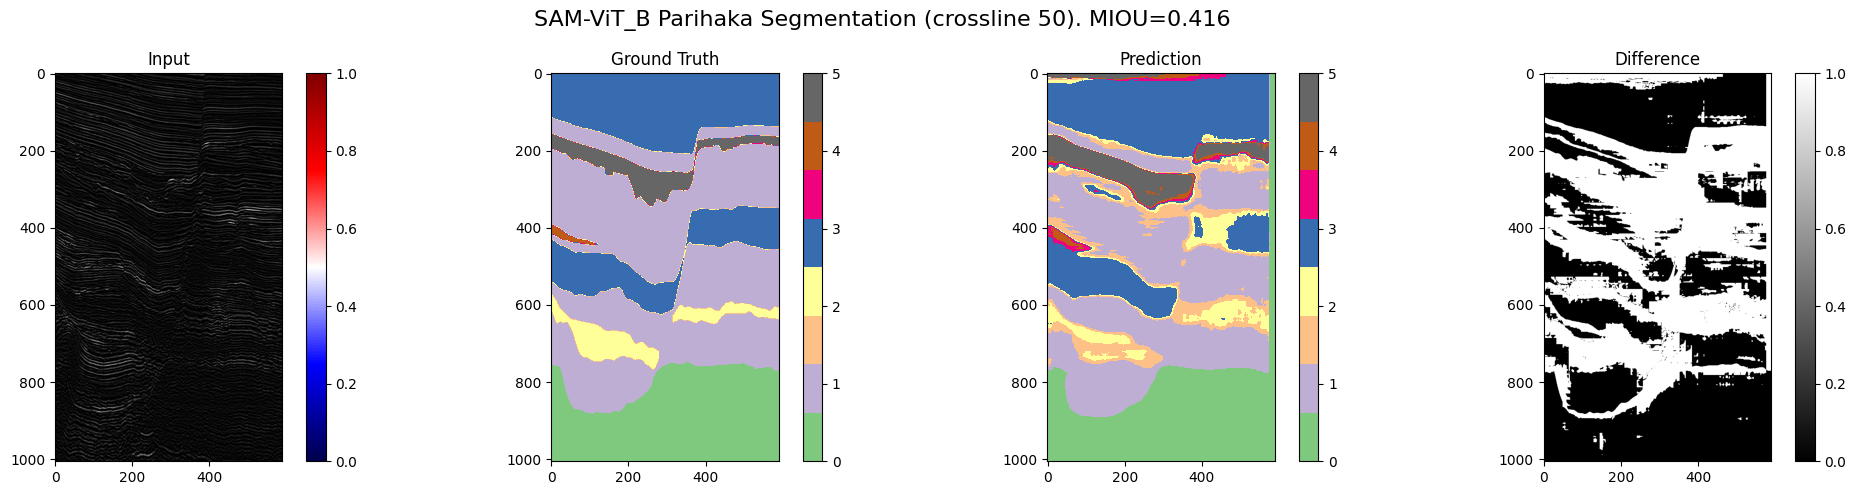

Testing: 51it [12:39, 15.21s/it]

Image 0: IoU = 0.4197


Testing: 52it [12:54, 15.12s/it]

Image 0: IoU = 0.4245


Testing: 53it [13:09, 15.05s/it]

Image 0: IoU = 0.4255


Testing: 54it [13:24, 15.00s/it]

Image 0: IoU = 0.4224


Testing: 55it [13:39, 14.97s/it]

Image 0: IoU = 0.4196


Testing: 56it [13:53, 14.95s/it]

Image 0: IoU = 0.4162


Testing: 57it [14:08, 14.93s/it]

Image 0: IoU = 0.4107


Testing: 58it [14:23, 14.94s/it]

Image 0: IoU = 0.3258


Testing: 59it [14:38, 14.96s/it]

Image 0: IoU = 0.4081


Testing: 60it [14:53, 14.95s/it]

Image 0: IoU = 0.4088


Testing: 61it [15:08, 14.94s/it]

Image 0: IoU = 0.4056


Testing: 62it [15:23, 14.93s/it]

Image 0: IoU = 0.4064


Testing: 63it [15:38, 14.94s/it]

Image 0: IoU = 0.4054


Testing: 64it [15:53, 14.93s/it]

Image 0: IoU = 0.4135


Testing: 65it [16:08, 14.93s/it]

Image 0: IoU = 0.4192


Testing: 66it [16:23, 14.92s/it]

Image 0: IoU = 0.4165


Testing: 67it [16:38, 14.93s/it]

Image 0: IoU = 0.4152


Testing: 68it [16:53, 14.94s/it]

Image 0: IoU = 0.4114


Testing: 69it [17:08, 14.94s/it]

Image 0: IoU = 0.3229


Testing: 70it [17:23, 14.94s/it]

Image 0: IoU = 0.4102


Testing: 71it [17:38, 14.96s/it]

Image 0: IoU = 0.4121


Testing: 72it [17:53, 14.98s/it]

Image 0: IoU = 0.4177


Testing: 73it [18:08, 15.00s/it]

Image 0: IoU = 0.4235


Testing: 74it [18:23, 15.02s/it]

Image 0: IoU = 0.4325


Testing: 75it [18:38, 15.05s/it]

Image 0: IoU = 0.4372


Testing: 76it [18:53, 15.04s/it]

Image 0: IoU = 0.4408


Testing: 77it [19:08, 14.99s/it]

Image 0: IoU = 0.4500


Testing: 78it [19:23, 14.96s/it]

Image 0: IoU = 0.4535


Testing: 79it [19:38, 14.97s/it]

Image 0: IoU = 0.4580


Testing: 80it [19:53, 14.99s/it]

Image 0: IoU = 0.3272


Testing: 81it [20:08, 14.99s/it]

Image 0: IoU = 0.4584


Testing: 82it [20:23, 15.00s/it]

Image 0: IoU = 0.4592


Testing: 83it [20:38, 14.99s/it]

Image 0: IoU = 0.4643


Testing: 84it [20:53, 14.98s/it]

Image 0: IoU = 0.4628


Testing: 85it [21:08, 14.98s/it]

Image 0: IoU = 0.4602


Testing: 86it [21:23, 14.98s/it]

Image 0: IoU = 0.4569


Testing: 87it [21:37, 14.96s/it]

Image 0: IoU = 0.4591


Testing: 88it [21:52, 14.94s/it]

Image 0: IoU = 0.4621


Testing: 89it [22:07, 14.92s/it]

Image 0: IoU = 0.4713


Testing: 90it [22:22, 14.91s/it]

Image 0: IoU = 0.4784


Testing: 91it [22:37, 14.92s/it]

Image 0: IoU = 0.3345


Testing: 92it [22:52, 14.92s/it]

Image 0: IoU = 0.4812


Testing: 93it [23:07, 14.91s/it]

Image 0: IoU = 0.4828


Testing: 94it [23:22, 14.94s/it]

Image 0: IoU = 0.4857


Testing: 95it [23:37, 14.97s/it]

Image 0: IoU = 0.4837


Testing: 96it [23:52, 14.99s/it]

Image 0: IoU = 0.4857


Testing: 97it [24:07, 14.98s/it]

Image 0: IoU = 0.4839


Testing: 98it [24:22, 14.99s/it]

Image 0: IoU = 0.4799


Testing: 99it [24:37, 14.99s/it]

Image 0: IoU = 0.4772


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 0: IoU = 0.4763
Crossline 100 MIOU: 0.47632163763046265
x.shape=(1006, 590, 3), y.shape=(1006, 590), y_hat.shape=(1006, 590), diff.shape=(1006, 590)
Figure saved as 'logs/seam_ai/SAM-ViT_B/segmentation_100.png'


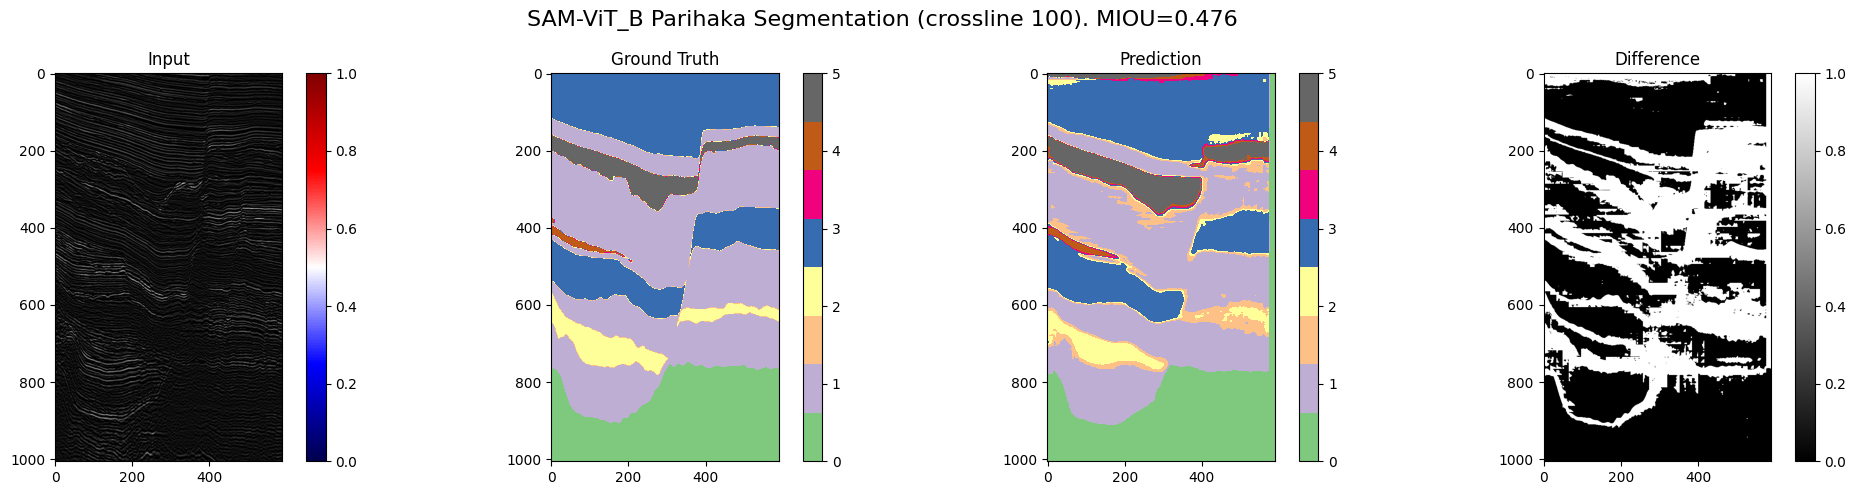

Testing: 101it [25:08, 15.18s/it]

Image 0: IoU = 0.4766


Testing: 102it [25:23, 15.08s/it]

Image 0: IoU = 0.3379


Testing: 103it [25:38, 15.03s/it]

Image 0: IoU = 0.4775


Testing: 104it [25:52, 15.00s/it]

Image 0: IoU = 0.4789


Testing: 105it [26:07, 14.96s/it]

Image 0: IoU = 0.4764


Testing: 106it [26:22, 14.93s/it]

Image 0: IoU = 0.4781


Testing: 107it [26:37, 14.92s/it]

Image 0: IoU = 0.4745


Testing: 108it [26:52, 14.93s/it]

Image 0: IoU = 0.4773


Testing: 109it [27:07, 14.90s/it]

Image 0: IoU = 0.4803


Testing: 110it [27:22, 14.90s/it]

Image 0: IoU = 0.4745


Testing: 111it [27:37, 14.90s/it]

Image 0: IoU = 0.4685


Testing: 112it [27:52, 14.92s/it]

Image 0: IoU = 0.4697


Testing: 113it [28:07, 14.93s/it]

Image 0: IoU = 0.3495


Testing: 114it [28:22, 14.93s/it]

Image 0: IoU = 0.3342


Testing: 115it [28:36, 14.94s/it]

Image 0: IoU = 0.3324


Testing: 116it [28:51, 14.96s/it]

Image 0: IoU = 0.3351


Testing: 117it [29:07, 15.03s/it]

Image 0: IoU = 0.3364


Testing: 118it [29:22, 15.04s/it]

Image 0: IoU = 0.3317


Testing: 119it [29:37, 15.01s/it]

Image 0: IoU = 0.3259


Testing: 120it [29:52, 14.99s/it]

Image 0: IoU = 0.3221


Testing: 121it [30:07, 14.97s/it]

Image 0: IoU = 0.3256


Testing: 122it [30:22, 14.96s/it]

Image 0: IoU = 0.3257


Testing: 123it [30:36, 14.95s/it]

Image 0: IoU = 0.3309


Testing: 124it [30:51, 14.95s/it]

Image 0: IoU = 0.3514


Testing: 125it [31:06, 14.94s/it]

Image 0: IoU = 0.3390


Testing: 126it [31:21, 14.94s/it]

Image 0: IoU = 0.3279


Testing: 127it [31:36, 14.94s/it]

Image 0: IoU = 0.3280


Testing: 128it [31:51, 14.94s/it]

Image 0: IoU = 0.3286


Testing: 129it [32:06, 14.94s/it]

Image 0: IoU = 0.3382


Testing: 130it [32:21, 14.94s/it]

Image 0: IoU = 0.3440


Testing: 131it [32:36, 14.95s/it]

Image 0: IoU = 0.3447


Testing: 132it [32:51, 14.97s/it]

Image 0: IoU = 0.3416


Testing: 133it [33:06, 14.95s/it]

Image 0: IoU = 0.3437


Testing: 134it [33:21, 14.95s/it]

Image 0: IoU = 0.3436


Testing: 135it [33:36, 14.94s/it]

Image 0: IoU = 0.3513


Testing: 136it [33:51, 14.97s/it]

Image 0: IoU = 0.3523


Testing: 137it [34:06, 15.01s/it]

Image 0: IoU = 0.3556


Testing: 138it [34:21, 15.00s/it]

Image 0: IoU = 0.3552


Testing: 139it [34:36, 14.99s/it]

Image 0: IoU = 0.3535


Testing: 140it [34:51, 15.01s/it]

Image 0: IoU = 0.3526


Testing: 141it [35:06, 14.98s/it]

Image 0: IoU = 0.3514


Testing: 142it [35:21, 14.95s/it]

Image 0: IoU = 0.3541


Testing: 143it [35:36, 14.94s/it]

Image 0: IoU = 0.3560


Testing: 144it [35:51, 14.94s/it]

Image 0: IoU = 0.3574


Testing: 145it [36:05, 14.92s/it]

Image 0: IoU = 0.3587


Testing: 146it [36:20, 14.91s/it]

Image 0: IoU = 0.3513


Testing: 147it [36:35, 14.91s/it]

Image 0: IoU = 0.3582


Testing: 148it [36:50, 14.92s/it]

Image 0: IoU = 0.3609


Testing: 149it [37:05, 14.93s/it]

Image 0: IoU = 0.3623


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 0: IoU = 0.3602
Crossline 150 MIOU: 0.36023449897766113
x.shape=(1006, 590, 3), y.shape=(1006, 590), y_hat.shape=(1006, 590), diff.shape=(1006, 590)
Figure saved as 'logs/seam_ai/SAM-ViT_B/segmentation_150.png'


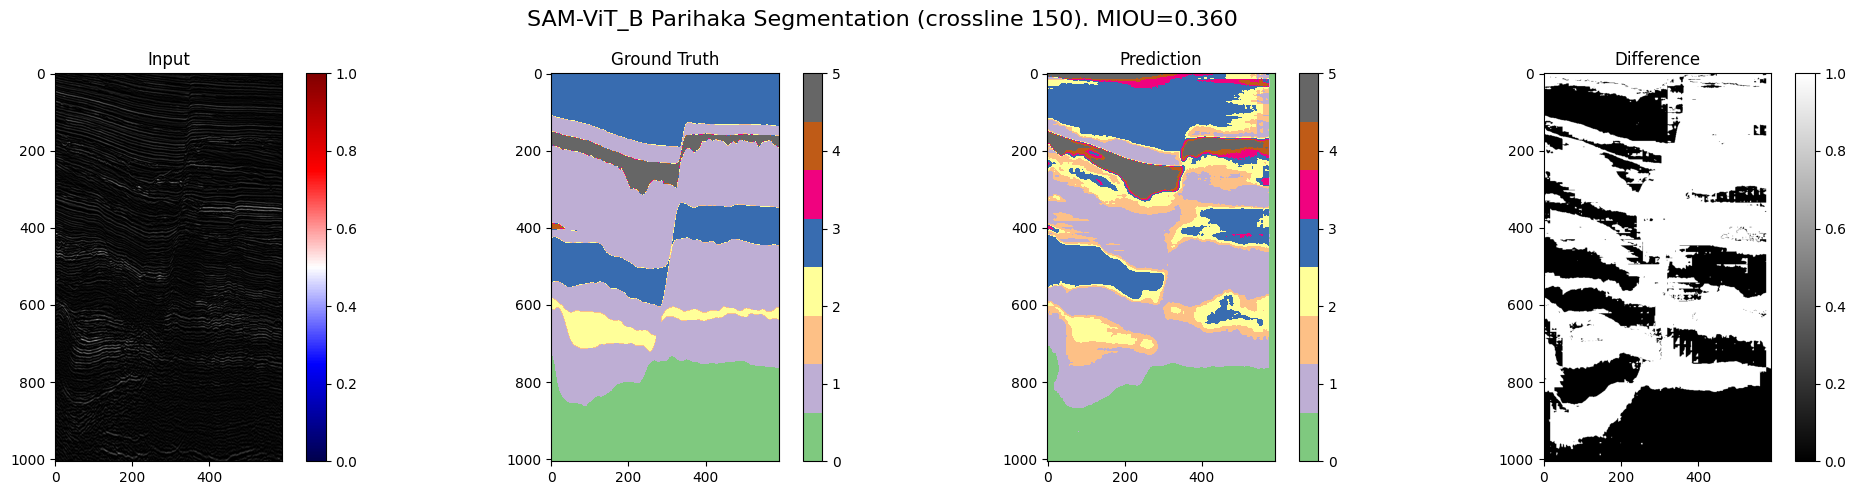

Testing: 151it [37:36, 15.18s/it]

Image 0: IoU = 0.3528


Testing: 152it [37:51, 15.16s/it]

Image 0: IoU = 0.3461


Testing: 153it [38:06, 15.11s/it]

Image 0: IoU = 0.3365


Testing: 154it [38:21, 15.06s/it]

Image 0: IoU = 0.3342


Testing: 155it [38:36, 15.03s/it]

Image 0: IoU = 0.3385


Testing: 156it [38:51, 15.04s/it]

Image 0: IoU = 0.3430


Testing: 157it [39:06, 15.00s/it]

Image 0: IoU = 0.3523


Testing: 158it [39:21, 14.98s/it]

Image 0: IoU = 0.3424


Testing: 159it [39:36, 14.96s/it]

Image 0: IoU = 0.3465


Testing: 160it [39:51, 15.01s/it]

Image 0: IoU = 0.3408


Testing: 161it [40:06, 15.07s/it]

Image 0: IoU = 0.3383


Testing: 162it [40:22, 15.12s/it]

Image 0: IoU = 0.3407


Testing: 163it [40:37, 15.17s/it]

Image 0: IoU = 0.3401


Testing: 164it [40:52, 15.17s/it]

Image 0: IoU = 0.3428


Testing: 165it [41:07, 15.14s/it]

Image 0: IoU = 0.3496


Testing: 166it [41:22, 15.12s/it]

Image 0: IoU = 0.3402


Testing: 167it [41:37, 15.12s/it]

Image 0: IoU = 0.3426


Testing: 168it [41:52, 15.15s/it]

Image 0: IoU = 0.3519


Testing: 169it [42:08, 15.14s/it]

Image 0: IoU = 0.3460


Testing: 170it [42:23, 15.12s/it]

Image 0: IoU = 0.3451


Testing: 171it [42:38, 15.11s/it]

Image 0: IoU = 0.3481


Testing: 172it [42:53, 15.09s/it]

Image 0: IoU = 0.3482


Testing: 173it [43:08, 15.10s/it]

Image 0: IoU = 0.3510


Testing: 174it [43:23, 15.13s/it]

Image 0: IoU = 0.3543


Testing: 175it [43:38, 15.18s/it]

Image 0: IoU = 0.3472


Testing: 176it [43:54, 15.15s/it]

Image 0: IoU = 0.3468


Testing: 177it [44:09, 15.12s/it]

Image 0: IoU = 0.3649


Testing: 178it [44:24, 15.09s/it]

Image 0: IoU = 0.3788


Testing: 179it [44:39, 15.06s/it]

Image 0: IoU = 0.3553


Testing: 180it [44:54, 15.04s/it]

Image 0: IoU = 0.3847


Testing: 181it [45:09, 15.04s/it]

Image 0: IoU = 0.3882


Testing: 182it [45:24, 15.03s/it]

Image 0: IoU = 0.3872


Testing: 183it [45:39, 15.06s/it]

Image 0: IoU = 0.3882


Testing: 184it [45:54, 15.08s/it]

Image 0: IoU = 0.3921


Testing: 185it [46:09, 15.11s/it]

Image 0: IoU = 0.3859


Testing: 186it [46:24, 15.10s/it]

Image 0: IoU = 0.3845


Testing: 187it [46:39, 15.08s/it]

Image 0: IoU = 0.3869


Testing: 188it [46:54, 15.05s/it]

Image 0: IoU = 0.3951


Testing: 189it [47:09, 15.03s/it]

Image 0: IoU = 0.3944


Testing: 190it [47:24, 15.03s/it]

Image 0: IoU = 0.3552


Testing: 191it [47:39, 15.03s/it]

Image 0: IoU = 0.3914


Testing: 192it [47:54, 15.02s/it]

Image 0: IoU = 0.3938


Testing: 193it [48:09, 15.01s/it]

Image 0: IoU = 0.3966


Testing: 194it [48:24, 15.01s/it]

Image 0: IoU = 0.3897


Testing: 195it [48:39, 15.00s/it]

Image 0: IoU = 0.3886


Testing: 196it [48:54, 14.99s/it]

Image 0: IoU = 0.3943


Testing: 197it [49:09, 14.99s/it]

Image 0: IoU = 0.3963


Testing: 198it [49:24, 14.98s/it]

Image 0: IoU = 0.3931


Testing: 199it [49:39, 15.01s/it]

Image 0: IoU = 0.3892


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 0: IoU = 0.3914
Crossline 200 MIOU: 0.3914209008216858
x.shape=(1006, 590, 3), y.shape=(1006, 590), y_hat.shape=(1006, 590), diff.shape=(1006, 590)
Figure saved as 'logs/seam_ai/SAM-ViT_B/segmentation_200.png'


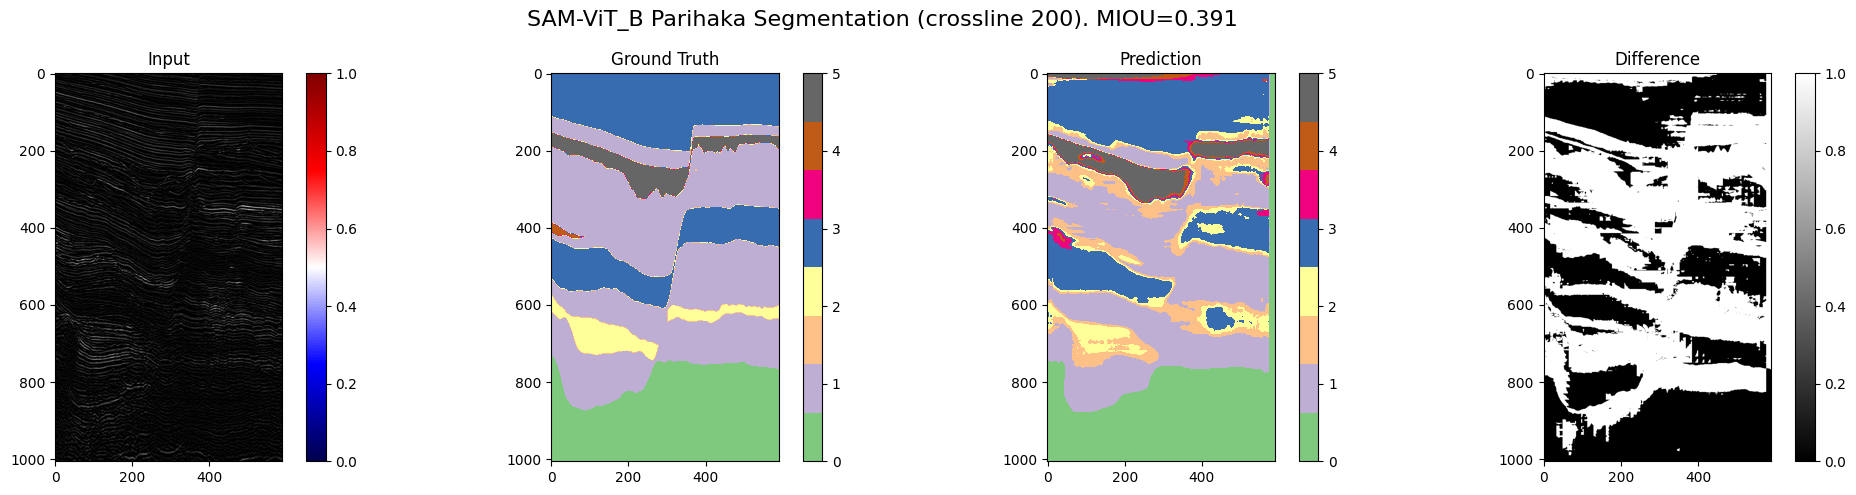

Testing: 200it [49:55, 14.98s/it]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
model.eval()
model = model.to("cuda")

miou_metric = JaccardIndex(task="multiclass", num_classes=num_classes).to(
    "cuda"
)
all_preds = []
metric_values = []

curent_index = 0

for batch_idx, (batch_x, batch_y) in tqdm.tqdm(
    enumerate(test_dataloader),
    desc="Testing",
    leave=True,
):
    preds = sliding_window_inference(data=batch_x.squeeze(0), label=batch_y, model=model, patch_size=image_height, stride=16, reflection_width=8)
    # debug
    # print(batch_idx, batch_x.squeeze(0).shape, batch_y.shape)
    # print(preds.shape)
    # plt.imshow(preds, cmap="viridis")  # Escolha o cmap, ex.: viridis, plasma, etc.
    # plt.colorbar(label="Classes")  # Adiciona a barra de cores para referência
    # plt.title("Segmentação por Classe")
    # plt.show()
    
    for i, (x, y) in enumerate(zip(batch_x.permute(0, 3, 1, 2), batch_y)):
        y_hat = preds
        # print(i, x.shape, y.shape, y_hat.shape)
        # Adiciona dimensões de batch (necessário para a métrica)
        y_hat_tensor = torch.tensor(y_hat).unsqueeze(0).to("cuda")  # [1, H, W]
        all_preds.append(y_hat_tensor)
        y_tensor = torch.tensor(y).unsqueeze(0).to("cuda")  
        # print(y_hat_tensor.shape, y_tensor.shape)
        
        curent_index += 1
        
        # Calcula o mIoU
        res = miou_metric(y_hat_tensor, y_tensor).item()
        metric_values.append(res)
        print(f"Image {i}: IoU = {res:.4f}")
        
        if curent_index % print_crosslines_every == 0:
            x = x.permute(1, 2, 0).squeeze(0).cpu().numpy()
            y = y_tensor.squeeze(0).cpu().numpy()
            y_hat = y_hat_tensor.squeeze(0).cpu().numpy()
            diff = (y != y_hat).astype(np.int32)
            print(f"Crossline {curent_index} MIOU: {res}")
            print(
                f"x.shape={x.shape}, y.shape={y.shape}, y_hat.shape={y_hat.shape}, diff.shape={diff.shape}"
            )

            plot_images(
                images=[x, y, y_hat, diff],
                subplot_titles=[
                    "Input",
                    "Ground Truth",
                    "Prediction",
                    "Difference",
                ],
                cmaps=["seismic", "Accent", "Accent", "gray"],
                plot_title=f"{model_name} Parihaka Segmentation (crossline {curent_index}). MIOU={res:.3f}",
                filename=f"{output_dir}/segmentation_{curent_index}.png",
                show=True,
            )
    # break

# salvando
# np.save("all_preds.npy", np.array(all_preds))
np.save("miou_values.npy", np.array(metric_values))
mean_iou = np.mean(metric_values)
print(f"Mean IoU: {mean_iou:.4f}")

In [25]:
# Converta todos os tensores para a CPU e depois para NumPy
all_preds_cpu = [pred.cpu().numpy() for pred in all_preds]

# Agora você pode salvar a lista de arrays NumPy
np.save("all_preds.npy", all_preds_cpu)

## Evaluate model (NÃO USADO)

In [ ]:
# # data_module.setup("test")

# miou_metric = JaccardIndex(task="multiclass", num_classes=num_classes).to(
#     "cuda"
# )
# metric_values = []

# model.eval()
# model = model.to("cuda")

# curent_index = 0

# for batch_idx, (batch_x, batch_y) in tqdm.tqdm(
#     enumerate(test_dataloader),
#     desc="Testing",
#     leave=True,
# ):
#     batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
#     batch_y_hat = model.forward(batch_x, multimask_output=True, image_size=model.image_size)
#     probs = torch.softmax(batch_y_hat['masks'], dim=1)
#     batch_y_hat = torch.argmax(probs, dim=1).squeeze(1)
#     # print(batch_x.shape, batch_y.shape, batch_y_hat.shape)

#     for i, (x, y, y_hat) in enumerate(zip(batch_x, batch_y, batch_y_hat)):
#         # print(i, x.shape, y.shape, y_hat.shape)
#         curent_index += 1
#         res = miou_metric(
#             y_hat.unsqueeze(0), y.unsqueeze(0)
#         ).item()  # re-add batch dimension (unsqueeze(0))
#         metric_values.append(res)

#         # if curent_index % print_crosslines_every == 0:
#         #     x = x.permute(1, 2, 0).squeeze(0).cpu().numpy()
#         #     y = y.squeeze(0).cpu().numpy()
#         #     y_hat = y_hat.squeeze(0).cpu().numpy()
#         #     diff = (y != y_hat).astype(np.int32)
#             # print(f"Crossline {curent_index} MIOU: {res}")
#             # print(
#             #     f"x.shape={x.shape}, y.shape={y.shape}, y_hat.shape={y_hat.shape}, diff.shape={diff.shape}"
#             # )

#             # plot_images(
#             #     images=[x, y, y_hat, diff],
#             #     subplot_titles=[
#             #         "Input",
#             #         "Ground Truth",
#             #         "Prediction",
#             #         "Difference",
#             #     ],
#             #     cmaps=["seismic", "Accent", "Accent", "gray"],
#             #     plot_title=f"{model_name} Parihaka Segmentation (crossline {curent_index}). MIOU={res:.3f}",
#             #     filename=f"{output_dir}/segmentation_{curent_index}.png",
#             #     show=True,
#             # )

In [ ]:
# mean_iou = np.mean(metric_values)
# print(f"Mean IoU: {mean_iou:.4f}")
# with open(f"{output_dir}/mean_iou.txt", "w") as f:
#     f.write(f"{mean_iou:.4f}")